In [24]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [25]:
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

In [26]:
results = pd.read_csv('Frog_final_results.csv')
ms_results = pd.read_csv('Frog_MS_results.csv')
sample_info = pd.read_csv('Frog_sample_info.csv', index_col=0)

In [27]:
df = pd.read_csv('data/GSE65785_clutchApolyA_relative_TPM.csv', index_col=0)
df = df[sample_info.index]
df = df[df.sum(1) >= 3]  # Filter practically unobserved genes
dfm = np.log10(df + 1).T

In [28]:
import NaiveDE

In [29]:
dfm = NaiveDE.stabilize(df).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(ERCC) + np.log(num_genes)', rcond=1e-4).T

In [30]:
results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)
ms_results['pval'] = ms_results['pval'].clip_lower(ms_results.query('pval > 0')['pval'].min() / 2)
ms_results['qval'] = ms_results['qval'].clip_lower(ms_results.query('qval > 0')['qval'].min() / 2)

In [31]:
ms_results.model.value_counts()

SE        20499
linear      269
PER         241
Name: model, dtype: int64

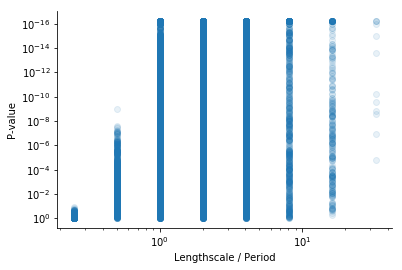

In [32]:
plt.loglog()
plt.scatter(results.l, results.pval, label='Genes', alpha=0.1);
plt.gca().invert_yaxis();
plt.xlabel('Lengthscale / Period')
plt.ylabel('P-value');

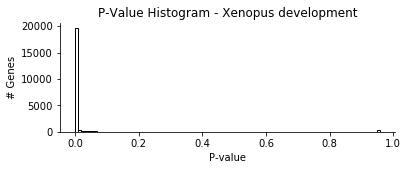

In [33]:
figsize(6, 2)
plt.hist(results.pval, bins=100, color='w', ec='k');
plt.title('P-Value Histogram - Xenopus development')
plt.ylabel('# Genes')
plt.xlabel('P-value');

In [34]:
results.query('qval < 0.05').shape

(21009, 19)

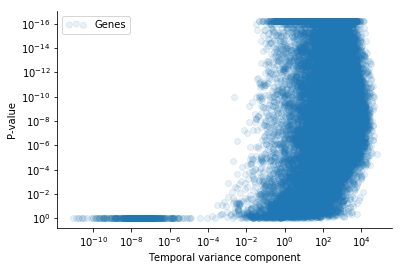

In [35]:
figsize(6, 4)

plt.loglog()
plt.scatter(results.max_s2_t_hat, results.pval, label='Genes', alpha=0.1);
plt.gca().invert_yaxis();
plt.xlabel('Temporal variance component')
plt.ylabel('P-value');

plt.legend(scatterpoints=3);

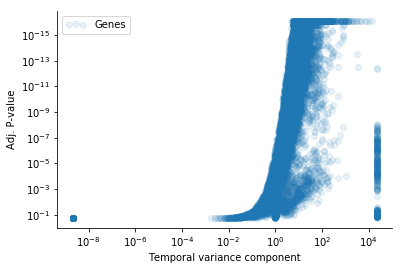

In [36]:
figsize(6, 4)

plt.loglog()
plt.scatter(1 / results.max_delta, results.qval, label='Genes', alpha=0.1);
plt.gca().invert_yaxis();
plt.xlabel('Temporal variance component')
plt.ylabel('Adj. P-value');

plt.legend(scatterpoints=3);

In [37]:
N = 5
top_per_ls = ms_results \
                  .sort_values('qval', ascending=True) \
                  .groupby(['model', 'l']) \
                  .head(N) \
                  .sort_values(['l', 'qval'], ascending=[True, True])
                
top_per_ls.shape

(71, 19)

In [38]:
model_colors = {'SE': 'C0', 'PER': 'C1', 'linear': 'C2'}

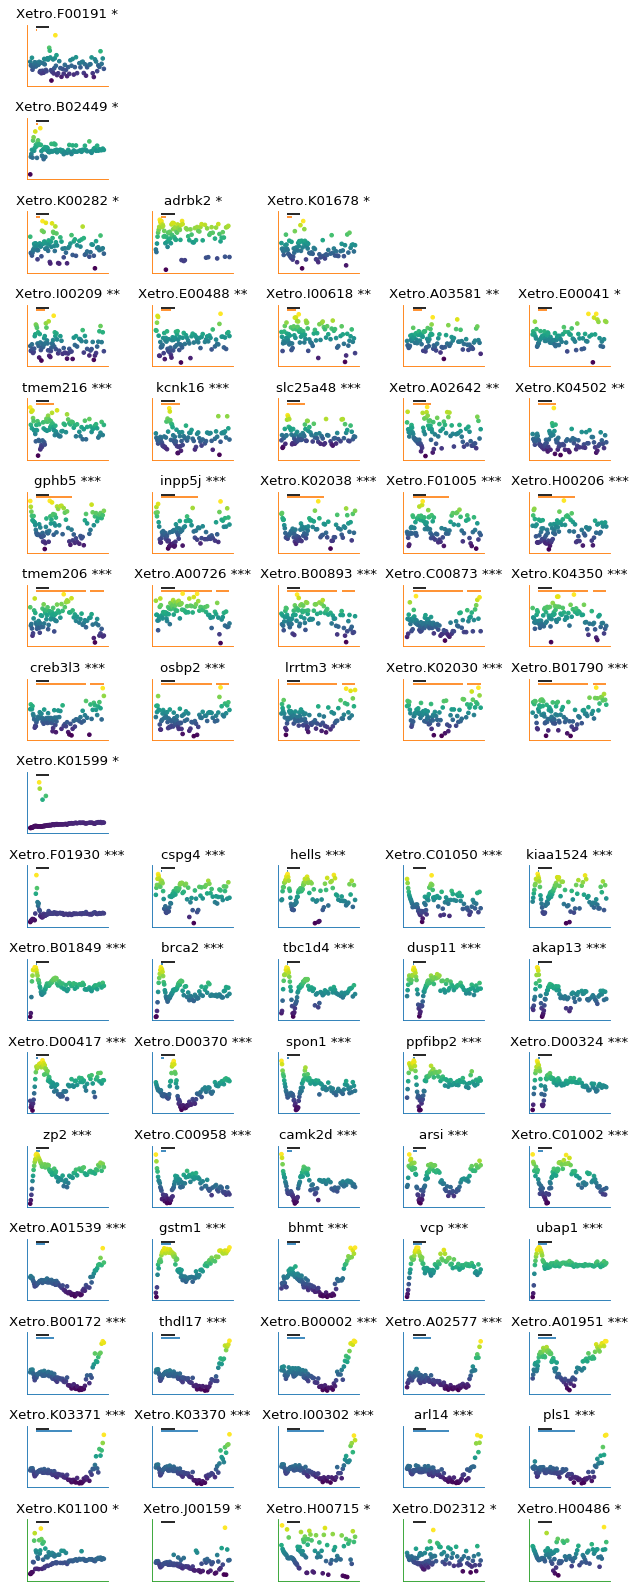

In [39]:
plt.figure(figsize=(8, 20), dpi=80)

N = 5
N_rows = top_per_ls.replace(np.nan, 0).groupby(['model', 'l']).size().shape[0]
for j, T in enumerate(top_per_ls.replace(np.nan, 0).groupby(['model', 'l'])):
    _, group = T
    for i, idx in enumerate(group.index):
        r = top_per_ls.loc[idx]
        ax = plt.subplot(N_rows, N, j * N + i + 1)

        plt.scatter(sample_info.hpf, res[r['g']], c=res[r['g']], s=10, rasterized=True);

        s = ' *'
        if r['qval'] < 0.01:
            s = ' **'

        if r['qval'] < 0.001:
            s = ' ***'

        name = r['g'].split('|')[-1].replace('unnamed', '')
        if name == '':
            name = r['g'].split('|')[0]
        plt.title(name + s)
        
        plt.xticks([])
        plt.yticks([])
        
        if 5 + r['l'] < 64:
            plt.hlines(ax.get_ylim()[1], 5, 5 + r['l'], color=model_colors[r['model']], zorder=0)
            
        else:
            if r['model'] != 'linear':
                y0 = ax.get_ylim()[1]
                plt.hlines(y0, 5, 50, color=model_colors[r['model']], zorder=0)
                plt.hlines(y0, 54, 66, color=model_colors[r['model']], zorder=0)

        plt.hlines(ax.get_ylim()[1], 5, 5 + 12)
        
        for spine in ax.spines.values():
            spine.set_edgecolor(model_colors[r['model']])

plt.tight_layout()
plt.savefig('top_frog_gene_grid.pdf')

In [40]:
sample_info.hpf.max()

66.0

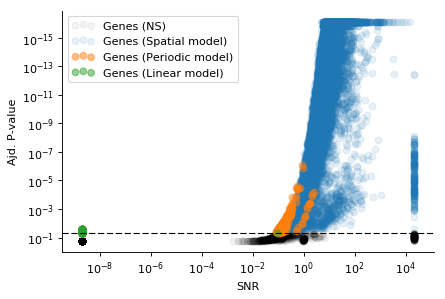

In [41]:
plt.figure(figsize=(6, 4), dpi=80)

plt.xscale('log')
plt.yscale('log')

tmp = results.query('qval > 0.05')
plt.scatter(1./ tmp['max_delta'], tmp['qval'],
            alpha=0.05, rasterized=True, label='Genes (NS)', marker='o', color='k');

tmp = ms_results.query('model == "SE"')
plt.scatter(1. / tmp['max_delta'], tmp['qval'],
            alpha=0.1, rasterized=True, label='Genes (Spatial model)', marker='o', color='C0');

tmp = ms_results.query('model == "PER"')
plt.scatter(1./ tmp['max_delta'], tmp['qval'],
            alpha=0.5, rasterized=True, label='Genes (Periodic model)', marker='o', color='C1');

tmp = ms_results.query('model == "linear"')
plt.scatter(1./ tmp['max_delta'], tmp['qval'],
            alpha=0.5, rasterized=True, label='Genes (Linear model)', marker='o', color='C2');

plt.axhline(0.05, ls='--', c='k', lw=1)
plt.xlabel('SNR');
plt.ylabel('Ajd. P-value');
plt.gca().invert_yaxis()

plt.legend(scatterpoints=3, loc='upper left');

plt.savefig('frog_variance_pval.pdf', dpi=200);

In [42]:
import SpatialDE.plot

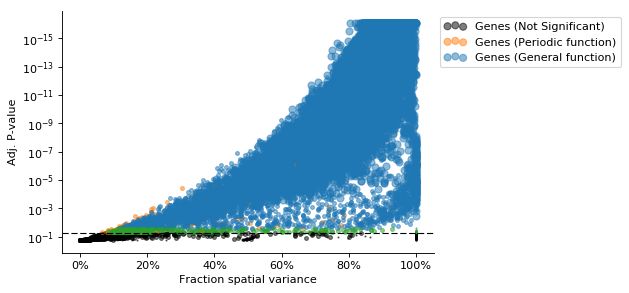

In [43]:
plt.figure(figsize=(6, 4), dpi=80)

SpatialDE.plot.FSV_sig(results, ms_results)

plt.savefig('frog_FSV_pval.pdf', dpi=200, bbox_inches='tight');

In [44]:
from sklearn.preprocessing import scale

In [45]:
top_genes = ms_results.sort_values('qval', ascending=True).head(400)

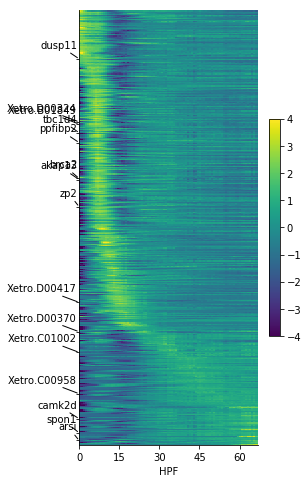

In [46]:
idx = np.argsort(np.argmax(dfm[top_genes['g']].as_matrix(), 0))[::-1]

figsize(4, 8)
plt.pcolormesh(scale(dfm[top_genes.iloc[idx]['g']].T, 1), vmax=4, vmin=-4, rasterized=True);
plt.colorbar(shrink=0.5);

x_locs = [0, 20, 40, 60, 80]
plt.xticks(x_locs, [int(i) for i in np.linspace(0, 66, 89)[x_locs]]);
plt.xlabel('HPF');

new_df = top_genes.iloc[idx][['g']].copy()
new_df['pos'] = np.arange(new_df.shape[0])
labels = new_df.merge(top_per_ls, on='g', how='inner')

plt.yticks(labels['pos'], [''] * len(labels['g']));

y_offsets = {
    'Xetro.D02289': -1,
    'Xetro.D02440': -1,
    'tctn2': -2,
    'Xetro.K02154': -40,
    'Xetro.K04277': -8,
    'itpkc': -20,
    'bix1.1': -2
}
x_offsets = {
    'bix1.1': -15,
    'itpkc': -10,
    'Xetro.K04277': -8,
}
for i, r in labels.iterrows():
    xy = (0, r['pos'])
    name = r['g'].split('|')[-1].replace('unnamed', '')
    if name == '':
        name = r['g'].split('|')[0]

    xyt = (xy[0] + x_offsets.get(name, -1), xy[1] + y_offsets.get(name, 10))
    plt.annotate(name, xy, xyt, horizontalalignment='right', arrowprops={'arrowstyle': '-'})

plt.savefig('top_frog_heatmap.pdf', bbox_inches='tight');